# Tutorial 3 – Mass Spectra Simulation

Mass spectrometry (MS) detects ionized peptides based on their mass-to-charge (m/z) ratios. In a typical LC-MS/MS workflow, the instrument first records an MS1 spectrum of intact peptide ions, selects targets for fragmentation, and then acquires MS2 spectra of the resulting fragments. In this tutorial you will simulate that pipeline computationally by computing peptide masses, simulating ionization, calculating m/z values, fragmenting peptides into b/y ions, and plotting the resulting spectra.

## Objectives
- Understand the basic workings of MS1 acquisition, peptide fragmentation, and MS2 acquisition.
- Calculate peptide and fragment ion masses plus m/z values.
- Practice string slicing to generate b- and y-ion fragments.
- Generate random intensity data for MS spectra using NumPy.
- Visualize MS1 and MS2 spectra using Matplotlib.
- Tools: slicing, random number generation, NumPy, Matplotlib.

---

## 1. Load the selected peptides
We reuse the `select_peptides.pkl` file produced in the LC tutorial. Each entry corresponds to a peptide that eluted within the targeted retention-time window.

> 🚩 **Fill in the triple dots [...]**

In [1]:
import pickle

with open('../results/select_peptides.pkl', 'rb') as handle:
    select_peps = pickle.load(handle)

len(select_peps)

8

---

## 2. Compute peptide masses
To simulate MS1 spectra we need the neutral molecular mass of each peptide. This is obtained by summing the masses of individual amino acids using a lookup table (dictionary).

Below is the dictionary used throughout the course. Feel free to check it against known monoisotopic masses if you’re curious.

In [2]:
amino_acid_mass_dalton = {
    'A': 71.08, 'R': 156.19, 'N': 114.10, 'D': 115.09,
    'C': 103.15, 'E': 129.12, 'Q': 128.13, 'G': 57.05,
    'H': 137.14, 'I': 113.16, 'L': 113.16, 'K': 128.17,
    'M': 131.19, 'F': 147.18, 'P': 97.12, 'S': 87.08,
    'T': 101.11, 'W': 186.21, 'Y': 163.18, 'V': 99.13,
}

## ⭐ Essential function: `calculate_mol_mass`
Implement a function that takes a single peptide sequence and returns a dictionary `{peptide: mass}` by summing the amino-acid masses. Use the `amino_acid_mass_dalton` mapping above.

> 🚩 **Fill in the triple dots [...]**

In [3]:
def calculate_mol_mass(peptide_seq, amino_acid_mass_dict):
    """
    Calculate the molecular mass of a peptide sequence.

    Parameters
    ----------
    peptide_seq : str
        The peptide sequence (e.g., "PEPTIDE").
    amino_acid_mass_dict : dict
        A dictionary mapping amino acid single-letter codes to their masses.
    Returns
    -------
    float
        The total molecular mass of the peptide.
    """
    total_mass = 0.0
    for aa in peptide_seq:
        total_mass += amino_acid_mass_dict[aa]
    return total_mass

Use your function to compute the mass of the peptide `PEPTIDE`.

In [4]:
peptide_mass = calculate_mol_mass("PEPTIDE", amino_acid_mass_dalton)
print(f"Mass of PEPTIDE: {peptide_mass} Da")

Mass of PEPTIDE: 781.84 Da


### ✅ Unit test: `calculate_mol_mass`

> 🚩 **Fill in the triple dots [...]**

In [5]:
def test_calculate_mol_mass():
    aa_mass_dict = {
        'A': 10, 'B': 20, 'C': 30, 'D': 40
    }
    test_peptide = "ABCD"
    expected_mass = 100
    calculated_mass = calculate_mol_mass(test_peptide, aa_mass_dict)
    assert calculated_mass == expected_mass

test_calculate_mol_mass()

## ⭐ Essential function: `calculate_mol_mass_collection`
Wrap the single-peptide function so it accepts a list of peptides and returns a dictionary mapping each peptide to its neutral mass.

> 🚩 **Fill in the triple dots [...]**

In [6]:
def calculate_mol_mass_collection(peptides, amino_acid_mass_dict):
    """
    Calculate the molecular masses for a collection of peptide sequences.
    
    Parameters
    ----------
    peptides : list of str
        A list of peptide sequences.
    amino_acid_mass_dict : dict
        A dictionary mapping amino acid single-letter codes to their masses.
    Returns
    -------
    dict
        A dictionary mapping peptide sequences to their calculated molecular masses.
    """
    mass_dict = {}
    for peptide in peptides:
        mass = calculate_mol_mass(peptide, amino_acid_mass_dict)
        mass_dict[peptide] = mass
    return mass_dict

Apply to the selected peptides. Compute the mass dictionary for your `select_peps` list. We will use this in the next section to calculate m/z values.

In [7]:
mass_map_ms1 = calculate_mol_mass_collection(select_peps, amino_acid_mass_dalton)
mass_map_ms1

{'MATSR': 546.65,
 'TYLDK': 620.71,
 'DVSLPR': 667.77,
 'GAFPPR': 625.74,
 'ISAFR': 574.69,
 'SEEAVR': 671.72,
 'AYVQAR': 688.79,
 'VLESYR': 747.8599999999999}

### ✅ Unit test: `calculate_mol_mass_collection`
Create a short list of peptides (e.g., `['AA', 'PEP']`), compute their masses with your function, and assert the dictionary matches the manually calculated values.

> 🚩 **Fill in the triple dots [...]**

In [8]:
def test_calculate_mol_mass_collection():
    aa_mass_dict = {
        'A': 10, 'B': 20, 'C': 30, 'D': 40
    }
    peptides = ["AB", "CD"]
    expected = {
        "AB": 30,
        "CD": 70,
    }
    actual = calculate_mol_mass_collection(peptides, aa_mass_dict)

    assert actual == expected

test_calculate_mol_mass_collection()

---

## 3. Simulate electrospray ionization
Before peptides enter the mass spectrometer they must be ionized. Electrospray ionization (ESI) gently adds extra protons as peptides travel through a mist, often yielding doubly charged ions for tryptic digests. To keep the simulation simple we treat every MS1 peptide as having a +2 charge state.

To convert a neutral mass into an m/z value, add the proton mass multiplied by the charge and then divide the sum by the charge: (neutral_mass + charge * proton_mass) / charge.

## ⭐ Essential function: `calculate_mz_collection`
Implement a function that accepts the peptide-mass dictionary from the previous step and returns a new dictionary mapping peptides to their m/z values. Default to `charge=2` and `proton_mass=1.007`.

> 🚩 **Fill in the triple dots [...]**

In [9]:
def calculate_mz_collection(peptide_mass_map, charge=2, proton_mass=1.007):
    """
    Calculate the m/z values for a collection of peptide masses.

    Parameters
    ----------
    peptide_mass_map : dict
        A dictionary mapping peptide sequences to their molecular masses.
    charge : int, optional
        The charge state of the peptides (default is 2).
    proton_mass : float, optional
        The mass of a proton (default is 1.007).
    Returns
    -------
    dict
        A dictionary mapping peptide sequences to their calculated m/z values.
    """
    mz_dict = {}
    for peptide, mass in peptide_mass_map.items():
        mz = (mass + (charge * proton_mass)) / charge
        mz_dict[peptide] = mz
    return mz_dict

Apply to MS1 masses: use `calculate_mz_collection` on `mass_map_ms1` so you have m/z values ready for plotting. Assume charge is +2.

In [10]:
mz1_map = calculate_mz_collection(mass_map_ms1)
mz1_map

{'MATSR': 274.332,
 'TYLDK': 311.362,
 'DVSLPR': 334.892,
 'GAFPPR': 313.877,
 'ISAFR': 288.35200000000003,
 'SEEAVR': 336.867,
 'AYVQAR': 345.402,
 'VLESYR': 374.93699999999995}

### ✅ Unit test: `calculate_mz_collection`
Create a tiny peptide-mass dictionary and assert that the function returns the expected m/z values for a chosen charge state.

> 🚩 **Fill in the triple dots [...]**

In [11]:
def test_calculate_mz_collection():
    peptide_mass_map = {"AB": 30, "CD": 70}
    actual = calculate_mz_collection(peptide_mass_map, charge=2, proton_mass=1.007)
    expected = {
        "AB": (30 + (2 * 1.007)) / 2,
        "CD": (70 + (2 * 1.007)) / 2
    }

    assert actual == expected

test_calculate_mz_collection()

---

## 4. Plot the MS1 spectrum
An MS1 spectrum displays peptide ion intensities (y-axis) versus their m/z values (x-axis). In silico we do not simulate detector noise or multiple counts per m/z, so we will generate random intensities for visualization purposes. Remember to set a random seed so the plot is reproducible. A seed is just a starting value for the random number generator so it produces the same sequence every time.

## ⭐ Essential function: `plot_spectrum`
Implement a function that accepts the m/z values and optional `random_count_range` to draw random intensities, then plots a bar chart using Matplotlib.

> 🚩 **Fill in the triple dots [...]**

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def plot_spectrum(mz_values, random_count_range=(0, 30000), seed=42):
    """
    Plot a simulated MS1 spectrum given m/z values.

    Parameters
    ----------
    mz_values : list or array-like
        A collection of m/z values to plot.
    random_count_range : tuple, optional
        The range (min, max) for random intensity counts (default is (0, 30000)).
    seed : int, optional
        Random seed for reproducibility (default is 42).

    Returns
    -------
    None  
    """
    np.random.seed(seed)
    counts = np.random.randint(random_count_range[0], random_count_range[1], size=len(mz_values))

    plt.figure(figsize=(10, 6))
    plt.bar(mz_values, counts, width=0.1)
    plt.xlabel('m/z')
    plt.ylabel('Intensity')
    plt.title('Simulated MS1 Spectrum')
    plt.show()

Set the seed to 42, generate random intensities, and plot the MS1 spectrum for `mz1_map` mass-charge ratios.

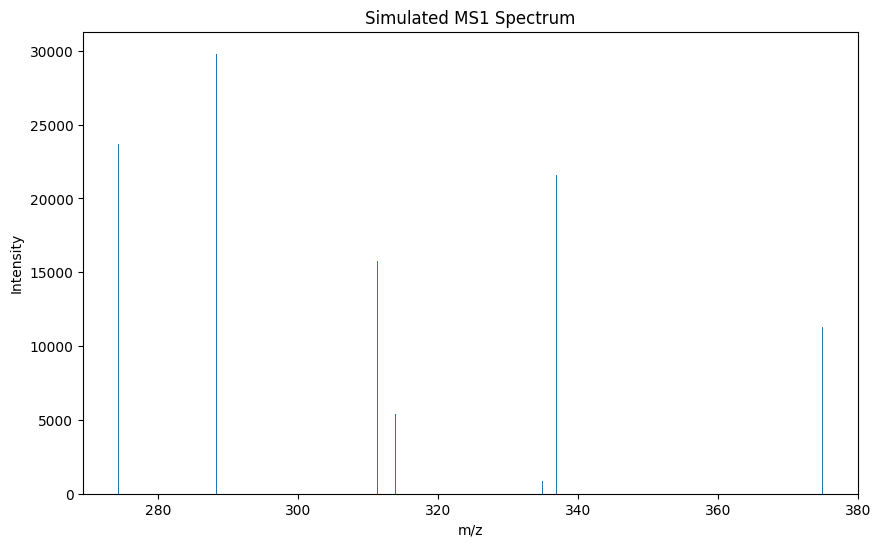

In [13]:
plot_spectrum(list(mz1_map.values()))

---

## 5. From MS1 to MS2 fragmentation
MS1 spectra tell us which peptides are present, but not their exact amino-acid order. Data-dependent acquisition (DDA) therefore picks a peptide, isolates it, and sends it into an inert gas (often nitrogen) for collision-induced fragmentation. The collisions break the peptide backbone, producing b-ions counted from the N-terminus and y-ions counted from the C-terminus. These fragment ladders are essential for decoding the precise sequence in MS2.

### 5.1 Fragment-ions example
Consider the peptide `PEPTIDE`.
- b-ion series (from the N-terminus): `P`, `PE`, `PEP`, `PEPT`, `PEPTI`, `PEPTID`, `PEPTIDE`.
- y-ion series (from the C-terminus): `E`, `DE`, `IDE`, `TIDE`, `PTIDE`, `EPTIDE`, `PEPTIDE`.

These ladders capture the incremental fragments generated in MS2.

## ⭐ Essential function: `fragment_peptide`
Implement a function that returns the combined list of b- and y-ion sequences for any peptide input.

> 🚩 **Fill in the triple dots [...]**

In [14]:
def fragment_peptide(peptide):
    """
    Generate b-ions and y-ions for a given peptide sequence.

    Parameters
    ----------
    peptide : str
        The peptide sequence to fragment.
    Returns
    -------
    list
        A list of fragment ions (b-ions and y-ions).
    """
    b_ions = []
    y_ions = []

    # Generate b-ions (N-terminal fragments)
    for i in range(1, len(peptide)):
        b_ions.append(peptide[:i])  # Slice from the beginning to i

    # Generate y-ions (C-terminal fragments)
    for i in range(1, len(peptide)):
        y_ions.append(peptide[-i:])  # Slice from the end to -i

    all_ions = b_ions + y_ions

    return all_ions

In [15]:
fragment_peptide("PEPTIDE")

['P',
 'PE',
 'PEP',
 'PEPT',
 'PEPTI',
 'PEPTID',
 'E',
 'DE',
 'IDE',
 'TIDE',
 'PTIDE',
 'EPTIDE']

### ✅ Unit test: `fragment_peptide`
Use a small peptide (e.g., `PEPT`) and assert that the function returns all expected b- and y-ions.

> 🚩 **Fill in the triple dots [...]**

In [16]:
def test_fragment_peptide():
    peptide = "PEPTIDE"
    expected = ['P', 'PE', 'PEP', 'PEPT', 'PEPTI', 'PEPTID', 'E', 'DE', 'IDE', 'TIDE', 'PTIDE', 'EPTIDE']
    actual = fragment_peptide(peptide)

    assert set(actual) == set(expected)

test_fragment_peptide()

### 5.2 Apply the workflow to `MATSR`
We now pick one peptide (`MATSR`) to simulate the entire MS2 pipeline: choose the peptide, fragment it into b/y ions, compute fragment masses, convert them to m/z with charge +1, and display the spectrum.

> 🚩 **Fill in the triple dots [...]**

#### 1) Select the peptide and fragment it

In [17]:
mypep = 'MATSR'
frags = fragment_peptide(mypep)
frags

['M', 'MA', 'MAT', 'MATS', 'R', 'SR', 'TSR', 'ATSR']

#### 2) Compute fragment masses

In [18]:
mass_map_ms2 = calculate_mol_mass_collection(frags, amino_acid_mass_dalton)
mass_map_ms2

{'M': 131.19,
 'MA': 202.26999999999998,
 'MAT': 303.38,
 'MATS': 390.46,
 'R': 156.19,
 'SR': 243.26999999999998,
 'TSR': 344.38,
 'ATSR': 415.46}

#### 3) Convert to m/z with charge = +1

In [19]:
mz2_map = calculate_mz_collection(mass_map_ms2)
mz2_map

{'M': 66.602,
 'MA': 102.142,
 'MAT': 152.697,
 'MATS': 196.237,
 'R': 79.102,
 'SR': 122.642,
 'TSR': 173.197,
 'ATSR': 208.737}

#### 4) Plot the MS2 spectrum

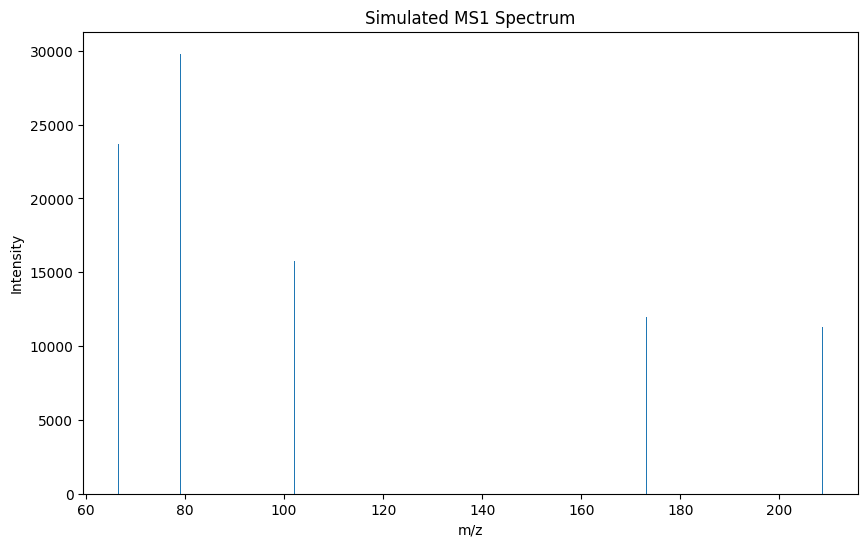

In [20]:
plot_spectrum(list(mz2_map.values()))

---

## 6. Export the MS results
You have now reached the end of the MS proteomics experiment. Let's save the MS1 and MS2 spectra results as TSV files.

### 6.1 MS1 peptide m/z values

> 🚩 **Fill in the triple dots [...]**

In [21]:
import pandas as pd

ms1_df = pd.DataFrame({
    'peptide': list(mz1_map.keys()),
    'mz': list(mz1_map.values()),
})

ms1_df.to_csv('../results/ms1_peptide_mzs.tsv', sep='\t', index=False)

### 6.2 MS2 `MATSR` fragment m/z values

> 🚩 **Fill in the triple dots [...]**

In [22]:
ms2_df = pd.DataFrame({
    'fragment': mz2_map.keys(),
    'mz': mz2_map.values(),
})

ms2_df.to_csv('../results/ms2_MATSR_fragment_mzs.tsv', sep='\t', index=False)